In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pickle

def load_pickle(fname):
    f = open(fname)
    var = pickle.load(f)
    f.close()
    return var

def dump_pickle(variable,fname):
    f = open(fname, 'w')
    pickle.dump(variable, f)
    f.close()
    return None


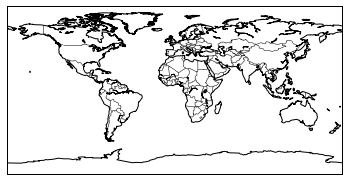

In [3]:
import plotly
plotly.__version__

import plotly.plotly as py
from plotly.graph_objs import *
import numpy as np           
from scipy.io import netcdf  
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
%matplotlib inline

# --- Load the zonal wind and QGPV at 240hPa --- #
u_QGPV_File = Dataset('u_QGPV_240hPa_2012Oct28to31.nc', mode='r')

# --- Read in longitude and latitude arrays --- #
lon = u_QGPV_File.variables['longitude'][:]
lat = u_QGPV_File.variables['latitude'][60:]
nlon = lon.size
nlat = lat.size
air = np.zeros((nlat,nlon))
LWA = np.zeros((nlat,nlon))

air = load_pickle('QGPV_140102_1800.pckl')[60:,:]
LWA = load_pickle('LWA_140102_1800.pckl')[60:,:]
# air[:,:] = u_QGPV_File.variables['QGPV'][0,0,60:,:]
# LWA[:,:] = u_QGPV_File.variables['U'][0,0,60:,:]


# Shift 'lon' from [0,360] to [-180,180], make numpy array
tmp_lon = np.array([lon[n]-360 if l>=180 else lon[n] 
                   for n,l in enumerate(lon)])  # => [0,180]U[-180,2.5]

i_east, = np.where(tmp_lon>=0)  # indices of east lon
i_west, = np.where(tmp_lon<0)   # indices of west lon
lon = np.hstack((tmp_lon[i_west], tmp_lon[i_east]))  # stack the 2 halves

# Correspondingly, shift the 'air' array
tmp_air = np.array(air)
air = np.hstack((tmp_air[:,i_west], tmp_air[:,i_east]))
tmp_LWA = np.array(LWA)
LWA = np.hstack((tmp_LWA[:,i_west], tmp_LWA[:,i_east]))

trace1 = Contour(
    z=air,
    x=lon,
    y=lat,
    type='heatmap',
    colorscale='Jet',
    connectgaps = True,
    zauto=False  # custom contour levels
#     colorscale='Jet',
#     zauto=True  # custom contour levels
)

trace2 = Contour(
    z=LWA,
    x=lon,
    y=lat,
    colorscale='Jet',
    type='heatmap',
    connectgaps = True,
    zauto=False  # custom contour levels
#     autocontour=False,
#     contours=dict(
#             start=0,
#             end=360,
#             size=15,)
)

# print 'finish tracer1'
# Make shortcut to Basemap object, 
# not specifying projection type for this example
m = Basemap();  

# print 'finish Basemap()'
# Make trace-generating function (return a Scatter object)


def make_scatter(x,y):
    return Scatter(
        x=x,
        y=y,
        mode='lines',
        line=Line(color="black"),
        name=' '  # no name on hover
    )
# print 'finish make_scatter'

# Functions converting coastline/country polygons to lon/lat traces
def polygons_to_traces(poly_paths, N_poly):
    ''' 
    pos arg 1. (poly_paths): paths to polygons
    pos arg 2. (N_poly): number of polygon to convert
    '''
    traces = []  # init. plotting list 

    for i_poly in range(N_poly):
        poly_path = poly_paths[i_poly]
        
        # get the Basemap coordinates of each segment
        coords_cc = np.array(
            [(vertex[0],vertex[1]) 
             for (vertex,code) in poly_path.iter_segments(simplify=False)]
        )
        
        # convert coordinates to lon/lat by 'inverting' the Basemap projection
        lon_cc, lat_cc = m(coords_cc[:,0],coords_cc[:,1], inverse=True)
        
        # add plot.ly plotting options
        traces.append(make_scatter(lon_cc,lat_cc))
     
    return traces

# Function generating coastline lon/lat traces
def get_coastline_traces():
    poly_paths = m.drawcoastlines().get_paths(); # coastline polygon paths
    N_poly = 91  # use only the 91st biggest coastlines (i.e. no rivers)
    return polygons_to_traces(poly_paths, N_poly)

# Function generating country lon/lat traces
def get_country_traces():
    poly_paths = m.drawcountries().get_paths(); # country polygon paths
    N_poly = len(poly_paths)  # use all countries
    return polygons_to_traces(poly_paths, N_poly)

# Get list of of coastline and country lon/lat traces
traces_cc = get_coastline_traces()+get_country_traces();

data = Data([trace1]+traces_cc)
data2 = Data([trace2]+traces_cc)

title1 = u"Quasi-geostrophic Potential Vorticity [1/s] at 490hPa on 2014/1/2 12:00UTC"
title2 = u"Local Wave Activity (FALWA [m/s]) at 490hPa on 2014/1/2 12:00UTC"

anno_text = "Data courtesy of \
<a href='http://www.esrl.noaa.gov/psd/data/composites/day/'>\
NOAA Earth System Research Laboratory</a>"

axis_style = dict(
    zeroline=False,
    showline=False,
    showgrid=False,
    ticks='',
    showticklabels=False,
)

layout1 = Layout(
    title=title1,
    showlegend=False,
    hovermode="closest",        # highlight closest point on hover
    xaxis=XAxis(
        axis_style,
        range=[lon[0],lon[-1]]  # restrict x-axis to range of lon
    ),
    yaxis=YAxis(
        axis_style,
        range=[lat[0],lat[-1]]  # restrict y-axis to range of lon
    ),
    annotations=Annotations([
        Annotation(
            text=anno_text,
            xref='paper',
            yref='paper',
            x=0,
            y=1,
            yanchor='bottom',
            showarrow=False
        )
    ]),
    autosize=False,
    width=1200,
    height=600,
)

layout2 = Layout(
    title=title2,
    showlegend=False,
    hovermode="closest",        # highlight closest point on hover
    xaxis=XAxis(
        axis_style,
        range=[lon[0],lon[-1]]  # restrict x-axis to range of lon
    ),
    yaxis=YAxis(
        axis_style,
        range=[lat[0],lat[-1]]  # restrict y-axis to range of lon
    ),
    annotations=Annotations([
        Annotation(
            text=anno_text,
            xref='paper',
            yref='paper',
            x=0,
            y=1,
            yanchor='bottom',
            showarrow=False
        )
    ]),
    autosize=False,
    width=1200,
    height=600,
)


# from IPython.display import display, HTML
# import urllib2
# url = 'https://raw.githubusercontent.com/plotly/python-user-guide/master/custom.css'
# display(HTML(urllib2.urlopen(url).read()))

In [4]:
fig = Figure(data=data, layout=layout1)

py.iplot(fig, filename="maps", width=800)


High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~csyhuang/0 or inside your plot.ly account where it is named 'maps'


In [5]:
fig2 = Figure(data=data2, layout=layout2)

py.iplot(fig2, filename="maps2", width=800)
